In [3]:
import calplot
import pandas as pd

In [46]:
df = pd.read_csv("2022_schedule.csv")
df

,date,time,home,away
0,2022-04-29,19:30:00,LA,NC
1,2022-04-30,15:00:00,POR,KC
2,2022-04-30,19:00:00,CHI,LOU
3,2022-05-01,17:00:00,WAS,RGN
4,2022-05-01,18:00:00,HOU,SD
...,...,...,...,...
132,2022-10-16,16:00:00,HOU,KC
133,2022-10-16,19:00:00,SD,CHI
134,2022-10-23,14:00:00,POR,SD
135,2022-10-23,16:30:00,RGN,KC


In [47]:
# change the type of data
df["date"] = pd.to_datetime(df["date"])
# Set orderdate as index
df.set_index("date", inplace=True)
df["data"] = 1

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


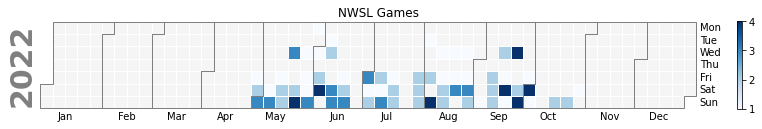

In [48]:
pl1 = calplot.calplot(
    data=df["home"],
    how="count",
    cmap="Blues",
    suptitle="NWSL Games",
    colorbar=True
)

In [49]:
# Fill in missing days of data with 0
df = df.groupby("date").agg({"home": "count"})
idx = pd.date_range(df.index.min(), df.index.max())
df = df.reindex(idx, fill_value=0)
df

,home
2022-04-29,1
2022-04-30,2
2022-05-01,3
2022-05-02,0
2022-05-03,0
...,...
2022-10-25,0
2022-10-26,0
2022-10-27,0
2022-10-28,0


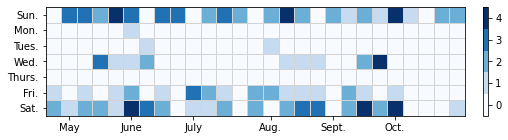

In [52]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt


DAYS = ["Sun.", "Mon.", "Tues.", "Wed.", "Thurs.", "Fri.", "Sat."]
MONTHS = [
    "Jan.",
    "Feb.",
    "Mar.",
    "Apr.",
    "May",
    "June",
    "July",
    "Aug.",
    "Sept.",
    "Oct.",
    "Nov.",
    "Dec.",
]


def date_heatmap(series, start=None, end=None, mean=False, ax=None, **kwargs):
    """Plot a calendar heatmap given a datetime series.

    Arguments:
        series (pd.Series):
            A series of numeric values with a datetime index. Values occurring
            on the same day are combined by sum.
        start (Any):
            The first day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            earliest date in the data.
        end (Any):
            The last day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            latest date in the data.
        mean (bool):
            Combine values occurring on the same day by mean instead of sum.
        ax (matplotlib.Axes or None):
            The axes on which to draw the heatmap. The default is the current
            axes in the :module:`~matplotlib.pyplot` API.
        **kwargs:
            Forwarded to :meth:`~matplotlib.Axes.pcolormesh` for drawing the
            heatmap.

    Returns:
        matplotlib.collections.Axes:
            The axes on which the heatmap was drawn. This is set as the current
            axes in the `~matplotlib.pyplot` API.
    """
    # Combine values occurring on the same day.
    dates = series.index.floor("D")
    group = series.groupby(dates)
    series = group.mean() if mean else group.sum()

    # Parse start/end, defaulting to the min/max of the index.
    start = pd.to_datetime(start or series.index.min())
    end = pd.to_datetime(end or series.index.max())

    # We use [start, end) as a half-open interval below.
    end += np.timedelta64(1, "D")

    # Get the previous/following Sunday to start/end.
    # Pandas and numpy day-of-week conventions are Monday=0 and Sunday=6.
    start_sun = start - np.timedelta64((start.dayofweek + 1) % 7, "D")
    end_sun = end + np.timedelta64(7 - end.dayofweek - 1, "D")

    # Create the heatmap and track ticks.
    num_weeks = (end_sun - start_sun).days // 7
    heatmap = np.zeros((7, num_weeks))
    ticks = {}  # week number -> month name
    for week in range(num_weeks):
        for day in range(7):
            date = start_sun + np.timedelta64(7 * week + day, "D")
            if date.day == 1:
                ticks[week] = MONTHS[date.month - 1]
            if date.dayofyear == 1:
                ticks[week] += f"\n{date.year}"
            if start <= date < end:
                heatmap[day, week] = series.get(date, 0)

    # Get the coordinates, offset by 0.5 to align the ticks.
    y = np.arange(8) - 0.5
    x = np.arange(num_weeks + 1) - 0.5

    # Plot the heatmap. Prefer pcolormesh over imshow so that the figure can be
    # vectorized when saved to a compatible format. We must invert the axis for
    # pcolormesh, but not for imshow, so that it reads top-bottom, left-right.
    ax = ax or plt.gca()
    mesh = ax.pcolormesh(x, y, heatmap, **kwargs)
    ax.invert_yaxis()

    # Set the ticks.
    ax.set_xticks(list(ticks.keys()))
    ax.set_xticklabels(list(ticks.values()))
    ax.set_yticks(np.arange(7))
    ax.set_yticklabels(DAYS)

    # Set the current image and axes in the pyplot API.
    plt.sca(ax)
    plt.sci(mesh)

    return ax


# Create the figure. For the aspect ratio, one year is 7 days by 53 weeks.
# We widen it further to account for the tick labels and color bar.
figsize = plt.figaspect(7 / 56)
fig = plt.figure(figsize=figsize)

# Plot the heatmap with a color bar.
ax = date_heatmap(df["home"], edgecolor="lightgray")
plt.colorbar(ticks=range(5), pad=0.02)

# Use a discrete color map with 5 colors (the data ranges from 0 to 4).
# Extending the color limits by 0.5 aligns the ticks in the color bar.
cmap = mpl.cm.get_cmap("Blues", 5)
plt.set_cmap(cmap)
plt.clim(-0.5, 4.5)

# Force the cells to be square. If this is set, the size of the color bar
# may look weird compared to the size of the heatmap. That can be corrected
# by the aspect ratio of the figure or scale of the color bar.
ax.set_aspect("equal")

# The firgure must be explicitly closed if it was not shown.
plt.show()